<a href="https://colab.research.google.com/github/Casare12/Casare12/blob/main/Transformer%20for%20mortality%20forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import svd
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("UK_total.csv") #use your preferred mortality data. You can download it from Human mortality database
df.head()

,Year,Age,MortalityRate
0,1922,0,0.0815
1,1922,1,0.02613
2,1922,2,0.012566
3,1922,3,0.006199
4,1922,4,0.004365


In [3]:
# Convert non-numeric values to NaN in the 'MortalityRate' column
df['MortalityRate'] = pd.to_numeric(df['MortalityRate'], errors='coerce')

# Replace NaN values with the mean of the 'MortalityRate' column
df['MortalityRate'] = df['MortalityRate'].fillna(df['MortalityRate'].mean())

# Replace zeros with a small positive value (like 1e-10) to avoid divide-by-zero errors
df['MortalityRate'] = df['MortalityRate'].replace(0, 1e-10)

In [4]:
# Pivot the data to have Age as index and Year as columns
pivot_df = df.pivot(index='Age', columns='Year', values='MortalityRate')
pivot_df.head()

Year,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Age,,,,,,,,,,,,,,,,,,,,,
0,0.081500,0.073306,0.080602,0.080413,0.075389,0.073641,0.071540,0.079018,0.066884,0.071244,...,0.004141,0.003857,0.003858,0.003886,0.003857,0.003894,0.003802,0.003911,0.003706,0.004028
1,0.026130,0.020113,0.023834,0.022358,0.019343,0.020380,0.017790,0.023967,0.014862,0.016554,...,0.000295,0.000311,0.000280,0.000278,0.000272,0.000206,0.000247,0.000234,0.000182,0.000211
2,0.012566,0.008106,0.009442,0.009013,0.007853,0.008665,0.007594,0.010154,0.006524,0.007032,...,0.000147,0.000161,0.000155,0.000142,0.000155,0.000144,0.000101,0.000144,0.000118,0.000130
3,0.006199,0.005457,0.005692,0.005689,0.004872,0.005194,0.004633,0.005812,0.004267,0.004484,...,0.000111,0.000111,0.000123,0.000115,0.000111,0.000102,0.000105,0.000091,0.000099,0.000091
4,0.004365,0.003448,0.004332,0.004135,0.003739,0.003815,0.003566,0.004165,0.003654,0.003542,...,0.000103,0.000102,0.000073,0.000098,0.000085,0.000096,0.000078,0.000074,0.000073,0.000050


In [5]:
# Prepare data for plotting
years = df['Year'].unique()
ages = np.arange(0, 101)
years_to_plot = np.arange(1950, 2022, 10)  # To Show years in 10-year intervals from 1950 to 2021

# Filter DataFrame to include only desired years
df_filtered = df[df['Year'].isin(years_to_plot)]

# Create meshgrid for 3D surface
X, Y = np.meshgrid(years_to_plot, ages)
Z = np.array([df_filtered[(df_filtered['Year'] == x) & (df_filtered['Age'] == y)]['MortalityRate'].values[0]
              if not df_filtered[(df_filtered['Year'] == x) & (df_filtered['Age'] == y)].empty else np.nan
              for y in ages for x in years_to_plot]).reshape(len(ages), len(years_to_plot))

# I saw some '.' in my data so replaced it with NaN
Z = np.where(Z == '.', np.nan, Z)

# Convert Z to a numeric type (float)
Z = Z.astype(np.float64)

# Replacing NaN values with the mean of their respective column
col_means = np.nanmean(Z, axis=0)
inds = np.where(np.isnan(Z))
Z[inds] = np.take(col_means, inds[1])

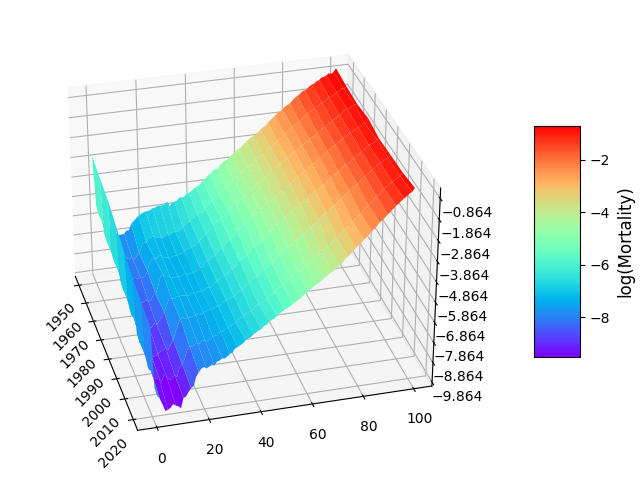

In [6]:
# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, np.log(Z), cmap='rainbow', edgecolor='none')

# Customize the view angle to move log(Mortality) to the right side
ax.view_init(elev=30, azim=-15)

# Customize tick labels
ax.set_xticks(np.arange(min(years_to_plot), max(years_to_plot) + 1, 10))
ax.set_yticks(np.arange(0, 101, 20))
ax.set_zticks(np.arange(np.log(Z[~np.isnan(Z)]).min(), np.log(Z[~np.isnan(Z)]).max(), 1))  # Adjust based on log scale

# Rotate x-axis labels for better readability
ax.set_xticklabels(np.arange(min(years_to_plot), max(years_to_plot) + 1, 10), rotation=45)
# Add colorbar on the right side
cbar = fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.1)
cbar.set_label('log(Mortality)', fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
# Prepare data for plotting
years = df['Year'].unique()
ages = np.arange(0, 101)  # Show all ages
# Include all years present in the dataset
years_to_plot = np.arange(min(years), max(years) + 1, 1)  # Ensuring all years are included

# Apply logarithm to the MortalityRate
df['logMortalityRate'] = np.log(df['MortalityRate'])

# Filter DataFrame to include only desired years
df_filtered = df[df['Year'].isin(years_to_plot)]

# Checking for the range of years in the filtered data
#print("Years in filtered data:", df_filtered['Year'].unique())


# Create a color map and normalize object
cmap = get_cmap('rainbow')
norm = Normalize(vmin=min(ages), vmax=max(ages))
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set array for the colorbar

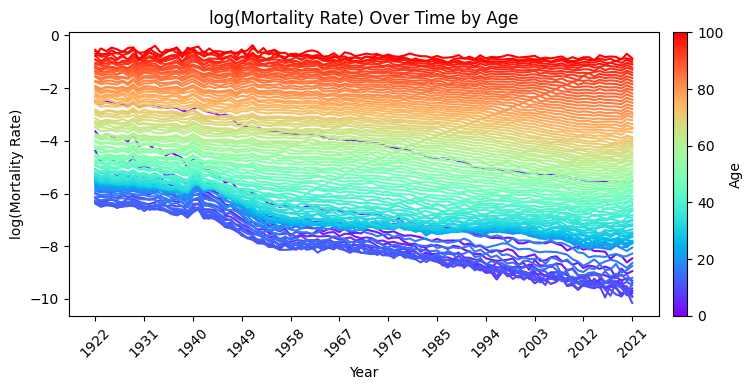

In [8]:
# Plot log mortality rate over time
fig, ax = plt.subplots(figsize=(8, 4))

for age in ages:
    age_data = df_filtered[df_filtered['Age'] == age]
    if not age_data.empty:
        color = cmap(norm(age))
        ax.plot(age_data['Year'], age_data['logMortalityRate'], color=color)

# Formatting the x-axis
ax.set_xlabel('Year')
ax.set_ylabel('log(Mortality Rate)')
ax.set_title('log(Mortality Rate) Over Time by Age')

# Adjust x-ticks to show every 10th year and rotate labels for visibility
ax.set_xticks(np.arange(min(years), max(years) + 1, 9))
ax.set_xticklabels(np.arange(min(years), max(years) + 1, 9), rotation=45)

# Create and display a colorbar as a heatmap
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Age')
cbar.set_ticks(np.linspace(min(ages), max(ages), num=6))  # Set ticks for clarity
cbar.set_ticklabels([f'{int(age)}' for age in np.linspace(min(ages), max(ages), num=6)])  # Set age labels

plt.tight_layout()
plt.show()

In [9]:
# Split the data into features (X) and targets (y)
X = pivot_df.loc[:, 1950:2019].values
y = pivot_df.loc[:, 2019:2021].values

# Take the logarithm of the mortality rates to stabilize variance
X = np.log(X)
y = np.log(y)

# Normalize X using StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize y using a separate StandardScaler
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

In [10]:
# Define a simple Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(input_dim, y_tensor.shape[1])

    def forward(self, src):
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

In [11]:
# Set the model parameters
input_dim = X_tensor.shape[1]  # Number of features (years from 1950 to 2019)
model_dim = 32  # Embedding dimension
nhead = 2  # Number of attention heads
num_encoder_layers = 1  # Number of encoder layers
num_decoder_layers = 1  # Number of decoder layers
dropout = 0.1  # Dropout rate
batch_size = 32  # Batch size for training
hidden_size = 16  # Size of the hidden layer (if applicable)
num_layers = 1  # Number of Transformer layers (usually the same as encoder/decoder layers)

num_epochs = 100  # Number of epochs for training

# Instantiate the model (assuming the model uses the input_dim, model_dim, nhead, num_encoder_layers, and dropout)
model = TransformerModel(input_dim, nhead, num_encoder_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate set to 0.001

In [12]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.6120
Epoch [2/100], Loss: 0.3132
Epoch [3/100], Loss: 0.2962
Epoch [4/100], Loss: 0.3395
Epoch [5/100], Loss: 0.2073
Epoch [6/100], Loss: 0.1716
Epoch [7/100], Loss: 0.1780
Epoch [8/100], Loss: 0.1494
Epoch [9/100], Loss: 0.1141
Epoch [10/100], Loss: 0.1256
Epoch [11/100], Loss: 0.1072
Epoch [12/100], Loss: 0.0826
Epoch [13/100], Loss: 0.0851
Epoch [14/100], Loss: 0.0808
Epoch [15/100], Loss: 0.0659
Epoch [16/100], Loss: 0.0675
Epoch [17/100], Loss: 0.0611
Epoch [18/100], Loss: 0.0646
Epoch [19/100], Loss: 0.0428
Epoch [20/100], Loss: 0.0450
Epoch [21/100], Loss: 0.0484
Epoch [22/100], Loss: 0.0430
Epoch [23/100], Loss: 0.0318
Epoch [24/100], Loss: 0.0371
Epoch [25/100], Loss: 0.0413
Epoch [26/100], Loss: 0.0368
Epoch [27/100], Loss: 0.0368
Epoch [28/100], Loss: 0.0314
Epoch [29/100], Loss: 0.0300
Epoch [30/100], Loss: 0.0259
Epoch [31/100], Loss: 0.0260
Epoch [32/100], Loss: 0.0345
Epoch [33/100], Loss: 0.0285
Epoch [34/100], Loss: 0.0228
Epoch [35/100], Loss: 0

In [13]:
# Predictions
model.eval()
with torch.no_grad():
    predictions = model(X_tensor)

# Reverse normalization (exponentiate and inverse scaling)
TS_predicted_values = scaler_y.inverse_transform(predictions.numpy())
actual_values = scaler_y.inverse_transform(y_tensor.numpy())

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MSE, RMSE, MAE, MAPE, and R² for each year (2019, 2020, 2021)
for i, year in enumerate([2019, 2020, 2021]):
    y_true = np.log(pivot_df[year])
    y_pred = TS_predicted_values[:, i]

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"Year {year} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

# Plot the results separately for each year
ages = pivot_df.index

Year 2019 - MSE: 0.0198, RMSE: 0.1407, MAE: 0.1117, MAPE: 6.79%, R²: 0.9976
Year 2020 - MSE: 0.0230, RMSE: 0.1515, MAE: 0.1275, MAPE: 6.13%, R²: 0.9973
Year 2021 - MSE: 0.0222, RMSE: 0.1490, MAE: 0.1161, MAPE: 5.80%, R²: 0.9973


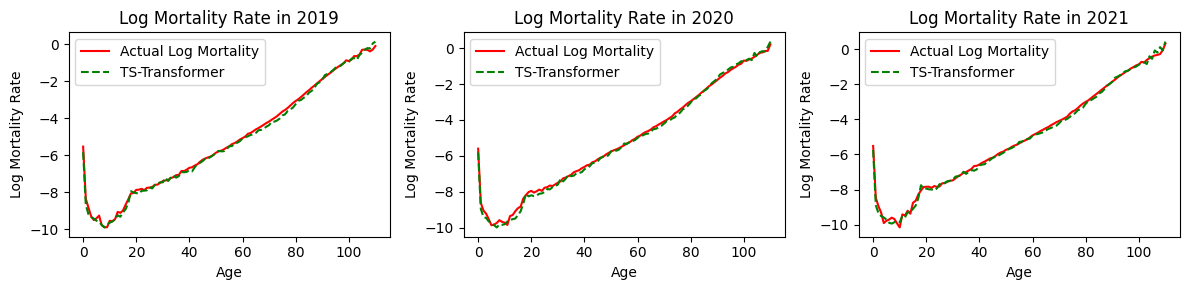

In [15]:
from numpy import math

# Number of test years
test_years = [2019, 2020, 2021]
num_test_years = len(test_years)

# Calculate grid size for subplots
rows = math.ceil(num_test_years / 3)
cols = 3

# Plot actual vs predicted log mortality rates for each test year
plt.figure(figsize=(cols * 4, rows * 3))

for i, year in enumerate(test_years):
    plt.subplot(rows, cols, i + 1)

    plt.plot(ages, np.log(pivot_df[year]), label='Actual Log Mortality', color='red')
    plt.plot(ages, TS_predicted_values[:, i], label='TS-Transformer', color='green', linestyle='--')

    plt.title(f'Log Mortality Rate in {year}')
    plt.xlabel('Age')
    plt.ylabel('Log Mortality Rate')
    plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Log transform the mortality rates
log_mortality_rates = np.log(pivot_df.values)

# Replace infs or NaNs with interpolation
log_mortality_rates = pd.DataFrame(log_mortality_rates).replace([np.inf, -np.inf], np.nan).interpolate(axis=1, limit_direction='both').values

# Calculate the mean across years (to be used for centering alpha)
alpha = np.mean(log_mortality_rates, axis=1)

# Center the log_mortality_rates matrix by subtracting alpha
log_mortality_rates_centered = log_mortality_rates - alpha[:, np.newaxis]

# Perform Singular Value Decomposition (SVD)
U, S, Vt = svd(log_mortality_rates_centered, full_matrices=False)

# Extract parameters
beta = U[:, 0]  # Age-specific constants (scaled)
kappa = S[0] * Vt[0, :]  # Time-specific coefficients (scaled)

# Normalize beta to sum to 1
beta = beta / np.sum(beta)

# Rescale kappa by adjusting the variance
kappa = kappa - np.mean(kappa)  # Center around zero

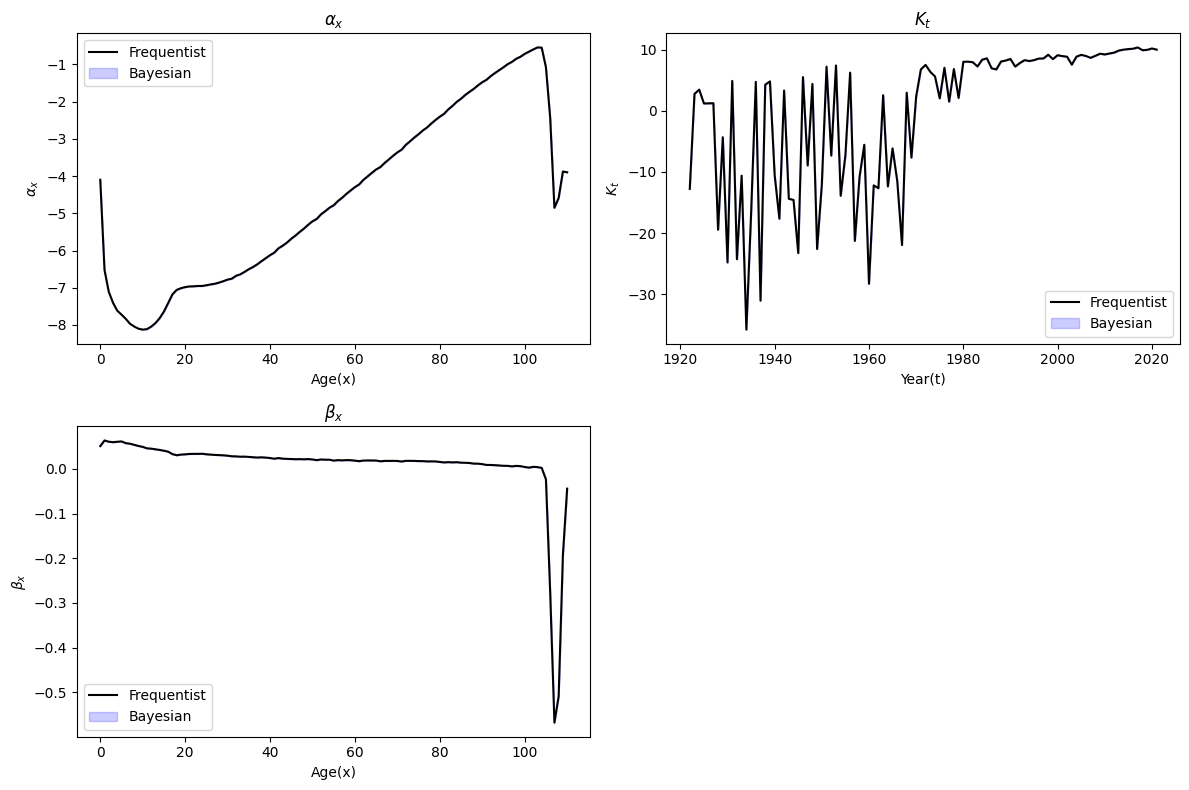

In [17]:
# Plot Alpha (α) vs. Age(x)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(pivot_df.index, alpha, 'k-', label='Frequentist')
plt.fill_between(pivot_df.index, alpha - 0, alpha + 0, color='blue', alpha=0.2, label='Bayesian')
plt.title(r'$\alpha_x$')
plt.xlabel('Age(x)')
plt.ylabel(r'$\alpha_x$')
plt.legend()

# Plot Kappa (κ) vs. Year(t)
plt.subplot(2, 2, 2)
plt.plot(pivot_df.columns, kappa, 'k-', label='Frequentist')
plt.fill_between(pivot_df.columns, kappa - 0, kappa + 0, color='blue', alpha=0.2, label='Bayesian')
plt.title(r'$K_t$')
plt.xlabel('Year(t)')
plt.ylabel(r'$K_t$')
plt.legend()

# Plot Beta (β) vs. Age(x)
plt.subplot(2, 2, 3)
plt.plot(pivot_df.index, beta, 'k-', label='Frequentist')
plt.fill_between(pivot_df.index, beta - 0, beta + 0, color='blue', alpha=0.2, label='Bayesian')
plt.title(r'$\beta_x$')
plt.xlabel('Age(x)')
plt.ylabel(r'$\beta_x$')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Extract years from the pivot_df columns
years = pivot_df.columns

# Create a DataFrame with kappa values and years as the index
kappa_df = pd.DataFrame({'kappa': kappa}, index=years)

# Print the kappa values for each year
print("Kappa values for each year:")
kappa_df.tail()

Kappa values for each year:


,kappa
Year,
2017,10.339409
2018,9.885097
2019,9.948075
2020,10.170837
2021,9.983177


In [19]:
# Use only the last year as the test set
train_size = int(0.97 * len(kappa))  # Use 97% of data for training
train_years = pivot_df.columns[:train_size]
test_years = pivot_df.columns[train_size:]

# Training and test data for kappa
kappa_train = kappa[:train_size]
kappa_test = kappa[train_size:]

# Actual log mortality rates for the test set
actual_mortality_test = log_mortality_rates[:, train_size:]

# Fit ARIMA(0, 1, 1) model on training kappa values (was used in the traditional lee-carter)
model = ARIMA(kappa_train, order=(0, 1, 0))
model_fit = model.fit()

In [20]:
# Forecast kappa values for the test years
forecast_steps = len(test_years)
predicted_kappa = model_fit.forecast(steps=forecast_steps)

In [21]:
# Reconstruct the log mortality rates using the predicted kappa
reconstructed_log_mortality = alpha[:, np.newaxis] + beta[:, np.newaxis] * predicted_kappa

# Calculate the RMSE, MAE, MAPE for the reconstructed log mortality rates
actual_log_mortality_flattened = actual_mortality_test.flatten()
reconstructed_log_mortality_flattened = reconstructed_log_mortality.flatten()
rmse = np.sqrt(mean_squared_error(actual_log_mortality_flattened, reconstructed_log_mortality_flattened))
mae = mean_absolute_error(actual_log_mortality_flattened, reconstructed_log_mortality_flattened)
mape = np.mean(np.abs((actual_log_mortality_flattened - reconstructed_log_mortality_flattened) /
                      (actual_log_mortality_flattened + 1e-10))) * 100

# Print the results
print(f'kappa RMSE: {rmse}')
print(f'kappa MAE: {mae}')
print(f'kappa MAPE: {mape:.2f}%')

# Calculate RMSE, MAE, and MAPE for each year (2019, 2020, 2021)
for i, year in enumerate([2019, 2020, 2021]):
    actual_log_mortality_year = np.log(pivot_df[year])
    reconstructed_log_mortality_year = reconstructed_log_mortality[:, i]

    rmse_year = np.sqrt(mean_squared_error(actual_log_mortality_year, reconstructed_log_mortality_year))
    mae_year = mean_absolute_error(actual_log_mortality_year, reconstructed_log_mortality_year)
    mape_year = np.mean(np.abs((actual_log_mortality_year - reconstructed_log_mortality_year) /
                               (actual_log_mortality_year + 1e-10))) * 100

    print(f"Year {year} - RMSE: {rmse_year:.4f}, MAE: {mae_year:.4f}, MAPE: {mape_year:.2f}%")

kappa RMSE: 1.9174367385883953
kappa MAE: 1.2618767238474342
kappa MAPE: 168.74%
Year 2019 - RMSE: 1.9092, MAE: 1.2925, MAPE: 137.00%
Year 2020 - RMSE: 1.9282, MAE: 1.2493, MAPE: 180.90%
Year 2021 - RMSE: 1.9149, MAE: 1.2438, MAPE: 188.32%


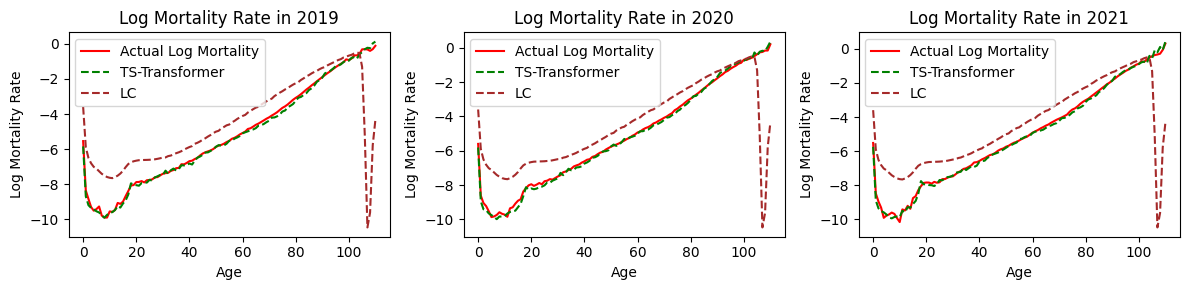

In [22]:
from numpy import math
# Number of test years
num_test_years = len(test_years)

# Calculate grid size for subplots
rows = math.ceil(num_test_years / 3)
cols = 3

# Plot actual vs reconstructed log mortality rates for each test year
plt.figure(figsize=(cols * 4, rows * 3))

for i, year in enumerate(test_years):
    plt.subplot(rows, cols, i + 1)

    plt.plot(pivot_df.index, actual_mortality_test[:, i], label='Actual Log Mortality', color='red')
    plt.plot(ages, TS_predicted_values[:, i], label='TS-Transformer', color='green', linestyle='--')
    plt.plot(pivot_df.index, reconstructed_log_mortality[:, i], label='LC', color='brown', linestyle='--')

    plt.title(f'Log Mortality Rate in {year}')
    plt.xlabel('Age')
    plt.ylabel('Log Mortality Rate')
    plt.legend()

plt.tight_layout()
plt.show()